In [6]:
import os
from collections import Counter, defaultdict

BASE_DIR = "../Sample_Data/Agency-files-documents"

In [7]:
# Function to Count File Types in Each Subfolder
def count_file_types(base_dir):
    folder_filetypes = defaultdict(Counter)

    for root, _, files in os.walk(base_dir):
        if not files:
            continue  # Skip empty folders

        # Folder name relative to the base directory
        folder_name = os.path.relpath(root, base_dir)

        for file in files:
            ext = os.path.splitext(file)[1].lower() or "no_extension"
            folder_filetypes[folder_name][ext] += 1

    return folder_filetypes

# Run the Function and Display Results
filetype_counts = count_file_types(BASE_DIR)

print("📂 File type summary by folder:\n")
for folder, counts in filetype_counts.items():
    print(f"📁 {folder}")
    for ext, count in counts.items():
        print(f"   {ext}: {count}")
    print("-" * 40)


📂 File type summary by folder:

📁 .
   no_extension: 1
----------------------------------------
📁 Agency Manual MA Combines Files
   .pdf: 1006
   .zip: 1
----------------------------------------
📁 Agency Manual NJ Combined Files
   .pdf: 1062
----------------------------------------


In [8]:
# -----------------------------------------------------------
# Explore PDF File Sizes (Highs, Lows & Averages)
# -----------------------------------------------------------
# In this step, we:
#   1️⃣  Walk through each folder under BASE_DIR.
#   2️⃣  Identify all PDF files.
#   3️⃣  Compute:
#         - Total count of PDFs
#         - Average file size
#         - Smallest (min) PDF file and its size
#         - Largest (max) PDF file and its size
#   4️⃣  Print a clean summary for each folder.
# -----------------------------------------------------------

import os
from collections import defaultdict

# 🧮 Helper: Convert bytes into human-readable format
def human_bytes(n):
    """Convert bytes into KB, MB, or GB for readability."""
    for unit in ["B", "KB", "MB", "GB"]:
        if n < 1024:
            return f"{n:.2f} {unit}"
        n /= 1024
    return f"{n:.2f} TB"


# 📂 Main Function: Analyze PDF file sizes across folders
def get_pdf_size_stats(base_dir):
    """
    Traverse through all subfolders under base_dir,
    and collect high/low/average size statistics for PDF files.
    """
    stats = defaultdict(lambda: {
        "count": 0,
        "total_bytes": 0,
        "min_bytes": float("inf"),
        "max_bytes": float("-inf"),
        "min_file": None,
        "max_file": None
    })

    for root, _, files in os.walk(base_dir):
        rel_folder = os.path.relpath(root, base_dir)
        for f in files:
            if f.lower().endswith(".pdf"):
                fpath = os.path.join(root, f)
                try:
                    size = os.path.getsize(fpath)
                except OSError:
                    continue  # skip unreadable files

                s = stats[rel_folder]
                s["count"] += 1
                s["total_bytes"] += size
                if size < s["min_bytes"]:
                    s["min_bytes"] = size
                    s["min_file"] = f
                if size > s["max_bytes"]:
                    s["max_bytes"] = size
                    s["max_file"] = f

    return stats


# 🧾 Step 5.1: Run the function on our base directory
pdf_stats = get_pdf_size_stats(BASE_DIR)

# 📊 Step 5.2: Display Summary (per folder)
print("📊 PDF Size Summary (Highs, Lows, and Averages):\n")
for folder, s in pdf_stats.items():
    if s["count"] == 0:
        continue  # skip folders without PDFs

    avg = s["total_bytes"] / s["count"]
    print(f"📁 {folder}")
    print(f"   PDFs: {s['count']} | Avg Size: {human_bytes(avg)}")
    print(f"   ▸ Smallest: {human_bytes(s['min_bytes'])} — {s['min_file']}")
    print(f"   ▸ Largest : {human_bytes(s['max_bytes'])} — {s['max_file']}")
    print("-" * 60)


📊 PDF Size Summary (Highs, Lows, and Averages):

📁 Agency Manual MA Combines Files
   PDFs: 1006 | Avg Size: 93.14 KB
   ▸ Smallest: 4.88 KB — BTC4_09.pdf
   ▸ Largest : 9.48 MB — BP-MU-2024-RU-001-C.pdf
------------------------------------------------------------
📁 Agency Manual NJ Combined Files
   PDFs: 1062 | Avg Size: 74.69 KB
   ▸ Smallest: 7.31 KB — NJ_ho_mso_fm518_200909.pdf
   ▸ Largest : 9.48 MB — NJ BP-MU-2024-RU-001-C.pdf
------------------------------------------------------------


In [9]:
# ============================================================
# A) Structural & Quality EDA  — extractability & content mix
# ============================================================
# Goal: for each PDF, estimate how much text is extractable
# and what proportion looks like narrative text vs tables/lists.
# Uses: pdfplumber (lightweight) and optional unstructured (richer)

import os, json
from collections import defaultdict
# import logging
# logging.getLogger("pdfminer").setLevel(logging.ERROR)     # hush “Cannot set gray…” etc.
# logging.getLogger("pdfplumber").setLevel(logging.ERROR)   # optional

# ✅ lightweight text/page stats via pdfplumber
try:
    import pdfplumber
except ImportError:
    raise ImportError("pip install pdfplumber")

def pdf_text_quality_stats(pdf_path):
    pages = 0
    text_pages = 0
    char_counts = []
    # count pages with extractable text
    with pdfplumber.open(pdf_path) as pdf:
        pages = len(pdf.pages)
        for p in pdf.pages:
            txt = (p.extract_text() or "").strip()
            if txt:
                text_pages += 1
                char_counts.append(len(txt))
    return {
        "pages": pages,
        "text_pages": text_pages,
        "pct_text_pages": (text_pages / pages * 100) if pages else 0.0,
        "avg_chars_per_text_page": (sum(char_counts)/len(char_counts)) if char_counts else 0.0
    }

# 🧱 optional: richer structure via unstructured (if installed)
try:
    from unstructured.partition.pdf import partition_pdf
    HAS_UNSTRUCTURED = True
except Exception:
    HAS_UNSTRUCTURED = False

def pdf_element_mix(pdf_path):
    """Return counts of semantic elements (Title, NarrativeText, List, Table, etc.)."""
    if not HAS_UNSTRUCTURED:
        return {}
    elems = partition_pdf(
        filename=pdf_path,
        strategy="fast",                # change to "hi_res" if OCR needed
        infer_table_structure=True
    )
    mix = defaultdict(int)
    for e in elems:
        mix[e.category] += 1
    return dict(mix)

# ▶️ run across the dataset (top-level and subfolders)
struct_rows = []
for root, _, files in os.walk(BASE_DIR):
    for f in files:
        if f.lower().endswith(".pdf"):
            fpath = os.path.join(root, f)
            basic = pdf_text_quality_stats(fpath)
            mix = pdf_element_mix(fpath)
            struct_rows.append({
                "folder": os.path.relpath(root, BASE_DIR),
                "file": f,
                **basic,
                "element_mix": json.dumps(mix) if mix else "{}"
            })

# 👀 quick preview of a few rows
print("sample:", struct_rows[:2])


Cannot set gray non-stroke color because /'P264' is an invalid float value
Cannot set gray non-stroke color because /'P266' is an invalid float value
Cannot set gray non-stroke color because /'P268' is an invalid float value
Cannot set gray non-stroke color because /'P269' is an invalid float value
Cannot set gray non-stroke color because /'P275' is an invalid float value
Cannot set gray non-stroke color because /'P276' is an invalid float value
Cannot set gray non-stroke color because /'P278' is an invalid float value
Cannot set gray non-stroke color because /'Pattern1' is an invalid float value
Cannot set gray non-stroke color because /'Pattern2' is an invalid float value
Cannot set gray non-stroke color because /'Pattern3' is an invalid float value
Cannot set gray non-stroke color because /'Pattern4' is an invalid float value
Cannot set gray non-stroke color because /'Pattern1' is an invalid float value
Cannot set gray non-stroke color because /'Pattern2' is an invalid float value


sample: [{'folder': 'Agency Manual MA Combines Files', 'file': 'CG 04 36 12 19.pdf', 'pages': 4, 'text_pages': 4, 'pct_text_pages': 100.0, 'avg_chars_per_text_page': 3207.25, 'element_mix': '{}'}, {'folder': 'Agency Manual MA Combines Files', 'file': 'CG 20 41 12 19.pdf', 'pages': 2, 'text_pages': 2, 'pct_text_pages': 100.0, 'avg_chars_per_text_page': 1159.5, 'element_mix': '{}'}]


In [10]:
# ============================================================
# Consolidated report from existing `struct_rows`
# ============================================================
import json
from collections import defaultdict

# 1) Parse element_mix (string -> dict)
def _parse_mix(x):
    try:
        return json.loads(x) if isinstance(x, str) else (x or {})
    except Exception:
        return {}

# 2) Basic totals
pdf_count = len(struct_rows)
total_pages = sum(r.get("pages", 0) for r in struct_rows)
total_text_pages = sum(r.get("text_pages", 0) for r in struct_rows)

# 3) Overall extractability (weighted by pages)
overall_pct_text_pages = (100.0 * total_text_pages / total_pages) if total_pages else 0.0

# 4) Weighted avg chars per *text* page across all PDFs
#    (use text_pages as weights; robust to zero-text PDFs)
num_chars_total = sum(
    (r.get("avg_chars_per_text_page", 0.0) or 0.0) * r.get("text_pages", 0)
    for r in struct_rows
)
weighted_avg_chars_per_text_page = (num_chars_total / total_text_pages) if total_text_pages else 0.0

# 5) Aggregate element mixes
agg_mix = defaultdict(int)
for r in struct_rows:
    mix = _parse_mix(r.get("element_mix", "{}"))
    for k, v in (mix or {}).items():
        agg_mix[k] += int(v) if isinstance(v, (int, float)) else 0

# 6) (Optional) by-folder summary (comment out if not needed)
by_folder = defaultdict(lambda: {"pdfs": 0, "pages": 0, "text_pages": 0})
for r in struct_rows:
    fld = r.get("folder", "")
    by_folder[fld]["pdfs"] += 1
    by_folder[fld]["pages"] += r.get("pages", 0)
    by_folder[fld]["text_pages"] += r.get("text_pages", 0)

folder_rows = []
for fld, m in by_folder.items():
    pct = (100.0 * m["text_pages"] / m["pages"]) if m["pages"] else 0.0
    folder_rows.append({
        "folder": fld,
        "pdf_count": m["pdfs"],
        "total_pages": m["pages"],
        "total_text_pages": m["text_pages"],
        "pct_text_pages": round(pct, 2),
    })

# 7) Build and print final
summary = {
    "pdf_count": pdf_count,
    "total_pages": total_pages,
    "total_text_pages": total_text_pages,
    "overall_pct_text_pages": round(overall_pct_text_pages, 2),
    "weighted_avg_chars_per_text_page": round(weighted_avg_chars_per_text_page, 2),
    "aggregated_element_mix": dict(agg_mix),
    "by_folder": folder_rows,  # remove if you don't want per-folder rollup
}

print("\n=== Consolidated Report ===")
print(json.dumps(summary, indent=2))



=== Consolidated Report ===
{
  "pdf_count": 2068,
  "total_pages": 7159,
  "total_text_pages": 7125,
  "overall_pct_text_pages": 99.53,
  "weighted_avg_chars_per_text_page": 2469.86,
  "aggregated_element_mix": {},
  "by_folder": [
    {
      "folder": "Agency Manual MA Combines Files",
      "pdf_count": 1006,
      "total_pages": 3951,
      "total_text_pages": 3934,
      "pct_text_pages": 99.57
    },
    {
      "folder": "Agency Manual NJ Combined Files",
      "pdf_count": 1062,
      "total_pages": 3208,
      "total_text_pages": 3191,
      "pct_text_pages": 99.47
    }
  ]
}


In [11]:
# ============================================================
# B) Text Statistics & Linguistic Patterns
# ============================================================
# Goal: compute word counts, lexical diversity, sentence lengths,
# and stopword ratio for quick quality checks.

import re
import statistics
from collections import Counter

# small helpers
def clean_text(t):
    t = re.sub(r"\s+", " ", t or "").strip()
    return t

# minimal tokenizer (no heavy deps)
WORD_RE = re.compile(r"[A-Za-z]+")
def tokenize_words(t):
    return WORD_RE.findall(t.lower())

SENT_RE = re.compile(r"[.!?]+")
def split_sentences(t):
    return [s.strip() for s in re.split(SENT_RE, t) if s.strip()]

# lightweight english stopword list (can swap in nltk if you prefer)
STOP = set("""
a an the and or but if while of in on for to from with at by as is are was were be been being
this that these those it its into about over under above below not no yes you your we our they their
""".split())

# collect stats for a small sample per folder to stay fast (tune N)
N_PER_FOLDER = 50

# reuse A) results to avoid re-reading PDFs; otherwise extract again via pdfplumber
folder_buckets = defaultdict(list)
for row in struct_rows:
    folder_buckets[row["folder"]].append(row)

linguistic_rows = []
for folder, rows in folder_buckets.items():
    rows = rows[:N_PER_FOLDER]
    for r in rows:
        # re-extract a single text blob for quick stats
        fpath = os.path.join(BASE_DIR, folder, r["file"])
        try:
            import pdfplumber
            parts = []
            with pdfplumber.open(fpath) as pdf:
                for p in pdf.pages:
                    parts.append(p.extract_text() or "")
            text = clean_text(" ".join(parts))
        except Exception:
            text = ""
        words = tokenize_words(text)
        sents = split_sentences(text)
        if not words:
            continue
        stop_ratio = sum(1 for w in words if w in STOP) / len(words)
        lex_div = len(set(words)) / len(words)
        avg_sent_len = (sum(len(tokenize_words(s)) for s in sents)/len(sents)) if sents else 0
        linguistic_rows.append({
            "folder": folder,
            "file": r["file"],
            "word_count": len(words),
            "lexical_diversity": round(lex_div, 4),
            "stopword_ratio": round(stop_ratio, 4),
            "avg_sentence_length_words": round(avg_sent_len, 2)
        })

# summarize by folder
folder_summary = defaultdict(lambda: {"docs":0,"avg_wc":0,"avg_lexdiv":0,"avg_stop":0,"avg_sentlen":0})
for row in linguistic_rows:
    s = folder_summary[row["folder"]]
    s["docs"] += 1
    s["avg_wc"] += row["word_count"]
    s["avg_lexdiv"] += row["lexical_diversity"]
    s["avg_stop"] += row["stopword_ratio"]
    s["avg_sentlen"] += row["avg_sentence_length_words"]

print("📊 Linguistic summary per folder:")
for f, s in folder_summary.items():
    n = max(s["docs"], 1)
    print(
        f"• {f} -> docs:{s['docs']}, "
        f"avg_wc:{int(s['avg_wc']/n)}, "
        f"lexdiv:{s['avg_lexdiv']/n:.3f}, "
        f"stop_ratio:{s['avg_stop']/n:.3f}, "
        f"avg_sentlen:{s['avg_sentlen']/n:.1f}"
    )


📊 Linguistic summary per folder:
• Agency Manual MA Combines Files -> docs:50, avg_wc:698, lexdiv:0.430, stop_ratio:0.342, avg_sentlen:15.0
• Agency Manual NJ Combined Files -> docs:50, avg_wc:602, lexdiv:0.454, stop_ratio:0.331, avg_sentlen:16.9


In [12]:
# ============================================================
# C) Semantic & Topical EDA (TF-IDF + NMF topics, similarity)
# ============================================================
# Goal: get a quick sense of recurring topics and near-duplicates.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

# build a small corpus: one text per PDF (sample to stay fast)
DOC_LIMIT_PER_FOLDER = 200
corpus, meta = [], []
for folder, rows in folder_buckets.items():
    for r in rows[:DOC_LIMIT_PER_FOLDER]:
        fpath = os.path.join(BASE_DIR, folder, r["file"])
        try:
            with pdfplumber.open(fpath) as pdf:
                text = " ".join((p.extract_text() or "") for p in pdf.pages)
        except Exception:
            text = ""
        if text.strip():
            corpus.append(text)
            meta.append((folder, r["file"]))

if not corpus:
    raise SystemExit("No text extracted for semantic EDA.")

# TF-IDF
tfidf = TfidfVectorizer(max_features=8000, stop_words="english")
X = tfidf.fit_transform(corpus)

# topics via NMF
k = 6  # number of topics (tune)
nmf = NMF(n_components=k, random_state=42, init="nndsvda", max_iter=500)
W = nmf.fit_transform(X)
H = nmf.components_
terms = tfidf.get_feature_names_out()

print("📚 Top words per topic:")
for i, comp in enumerate(H):
    top_idx = comp.argsort()[-12:]
    print(f"  Topic {i+1}: " + ", ".join(terms[j] for j in top_idx))

# quick duplicate check (pairwise similarity on a small subset)
subset = min(200, X.shape[0])
S = cosine_similarity(X[:subset])
# report pairs above threshold (excluding self matches)
THRESH = 0.85
pairs = []
for i in range(subset):
    for j in range(i+1, subset):
        if S[i, j] >= THRESH:
            pairs.append((i, j, round(float(S[i, j]), 3)))
print(f"\n🔍 Near-duplicate pairs (top {len(pairs)}):")
for i, j, sim in pairs[:10]:
    print(f"  {meta[i]}  <->  {meta[j]}  (sim={sim})")


📚 Top words per topic:
  Topic 1: described, cause, insurance, limit, caused, pay, building, coverage, damage, covered, property, loss
  Topic 2: exclusions, property, cg, personal, paragraph, exclusion, damage, insured, advertising, liability, bodily, injury
  Topic 3: person, organization, limits, shown, schedule, required, agreement, contract, insurance, afforded, insured, additional
  Topic 4: insuring, premises, limit, shown, insurance, policy, government, schedule, theft, cr, employee, crime
  Topic 5: 02, insurance, businessowners, completed, bp, policy, products, coverage, endorsement, liability, operations, cid
  Topic 6: 50, dedham, yes, 100, mutual, ho, unit, 10, deductible, limit, 500, 000

🔍 Near-duplicate pairs (top 16):
  ('Agency Manual MA Combines Files', 'Installation Application i.pdf')  <->  ('Agency Manual MA Combines Files', 'Commercial Fine Arts Application.pdf')  (sim=0.903)
  ('Agency Manual MA Combines Files', 'MS_RS_06_03_07.pdf')  <->  ('Agency Manual MA Com

In [14]:
# ============================================================
# D) Chunking Simulation (for RAG) — size & counts
# ============================================================
# Goal: simulate different chunk sizes/overlaps and measure
# number of chunks and token lengths to guide design.

# pip install langchain tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter
import tiktoken

enc = tiktoken.get_encoding("cl100k_base")

def token_len(txt):  # approximate token counts
    return len(enc.encode(txt or ""))

# choose a couple of representative docs
sample_docs = corpus[:10] if len(corpus) >= 10 else corpus

configs = [
    {"chunk_size": 700, "overlap": 100},
    {"chunk_size": 1000, "overlap": 150},
    {"chunk_size": 1500, "overlap": 200},
]

print("📦 Chunking comparison:")
for cfg in configs:
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=cfg["chunk_size"],
        chunk_overlap=cfg["overlap"],
        separators=["\n\n", "\n", " ", ""],
    )
    all_chunks = []
    for doc in sample_docs:
        all_chunks.extend(splitter.split_text(doc))
    token_counts = [token_len(c) for c in all_chunks]
    n = len(token_counts)
    avg_tok = sum(token_counts)/n if n else 0
    print(
        f"  size={cfg['chunk_size']}, overlap={cfg['overlap']} -> "
        f"chunks:{n}, avg_tokens:{avg_tok:.0f}, "
        f"min:{min(token_counts) if n else 0}, max:{max(token_counts) if n else 0}"
    )


📦 Chunking comparison:
  size=700, overlap=100 -> chunks:208, avg_tokens:151, min:40, max:188
  size=1000, overlap=150 -> chunks:146, avg_tokens:219, min:63, max:263
  size=1500, overlap=200 -> chunks:97, avg_tokens:325, min:80, max:373


In [15]:
# ============================================================
# E) Embedding Readiness — token budget & outliers
# ============================================================
# Goal: estimate total tokens for embeddings and flag extremes.

# reuse enc & corpus from above
token_counts = [len(enc.encode(t)) for t in corpus]
total_tokens = sum(token_counts)
avg_tokens = total_tokens / len(token_counts)

# identify very short and very long docs (5th & 95th percentiles)
import numpy as np
p5, p95 = np.percentile(token_counts, [5, 95])

print(f"🧮 Embedding token estimate:")
print(f"  docs: {len(token_counts)}")
print(f"  total tokens: {total_tokens:,}")
print(f"  avg per doc: {avg_tokens:.0f}")
print(f"  P5={int(p5)}, P95={int(p95)}")

# list a few extremes
long_idx = np.argsort(token_counts)[-5:][::-1]
short_idx = np.argsort(token_counts)[:5]
print("\n📌 Longest docs:")
for i in long_idx:
    print(f"  {meta[i]}  -> {token_counts[i]} tokens")
print("\n📌 Shortest docs:")
for i in short_idx:
    print(f"  {meta[i]}  -> {token_counts[i]} tokens")


🧮 Embedding token estimate:
  docs: 400
  total tokens: 590,932
  avg per doc: 1477
  P5=173, P95=5457

📌 Longest docs:
  ('Agency Manual MA Combines Files', 'PROPOSED MA PPA RATE PAGES - 07-01-25.pdf')  -> 60804 tokens
  ('Agency Manual MA Combines Files', 'BP-MA-2024-RU-001.pdf')  -> 18399 tokens
  ('Agency Manual MA Combines Files', 'HO 00 06 05 11.pdf')  -> 18136 tokens
  ('Agency Manual NJ Combined Files', 'NJ CU_00_01_04_13.pdf')  -> 16245 tokens
  ('Agency Manual MA Combines Files', 'MS_RS_01_07_13.pdf')  -> 15690 tokens

📌 Shortest docs:
  ('Agency Manual NJ Combined Files', 'NJ CM_99_04_07_88.pdf')  -> 105 tokens
  ('Agency Manual MA Combines Files', 'BP_02_10_09_12.pdf')  -> 120 tokens
  ('Agency Manual MA Combines Files', 'CG_22_27_11_85.pdf')  -> 121 tokens
  ('Agency Manual NJ Combined Files', 'NJ CU_00_22_05_13.pdf')  -> 128 tokens
  ('Agency Manual MA Combines Files', 'BT_13_10_01_14.pdf')  -> 134 tokens


In [16]:
# ============================================================
# F) Semantic Search Simulation (pre-embedding sanity check)
# ============================================================
# Goal: try simple retrieval using TF-IDF to see if realistic
# queries pull the expected docs — quick proxy before embeddings.

from sklearn.metrics.pairwise import linear_kernel

# build a shared TF-IDF model (reuse X, tfidf from step C)
def search(query, top_k=5):
    qv = tfidf.transform([query])
    sims = linear_kernel(qv, X).ravel()
    idx = sims.argsort()[-top_k:][::-1]
    return [(meta[i], float(sims[i])) for i in idx]

# try a few domain queries you care about
queries = [
    "licensing requirements for agencies",
    "compliance audit procedures",
    "claims processing timeline",
]

print("🔎 TF-IDF search results:")
for q in queries:
    hits = search(q, top_k=5)
    print(f"\nQ: {q}")
    for (folder, fname), score in hits:
        print(f"  -> {folder}/{fname}  (score={score:.3f})")


🔎 TF-IDF search results:

Q: licensing requirements for agencies
  -> Agency Manual NJ Combined Files/NJ HOBP_HO0455_0511 (1).pdf  (score=0.295)
  -> Agency Manual MA Combines Files/ho_rdc_09_200904.pdf  (score=0.143)
  -> Agency Manual NJ Combined Files/NJ I Dwelling_Fire_Application_11_20_15.pdf  (score=0.052)
  -> Agency Manual MA Combines Files/CP_04_05_09_17.pdf  (score=0.042)
  -> Agency Manual MA Combines Files/WOOD BURNING STOVE 01 13 09.pdf  (score=0.038)

Q: compliance audit procedures
  -> Agency Manual NJ Combined Files/NJ CG_21_59_04_13.pdf  (score=0.117)
  -> Agency Manual MA Combines Files/CG_21_59_04_13.pdf  (score=0.117)
  -> Agency Manual MA Combines Files/HO 24 41 09 01 Lead Poisoning Exclusion - MA.pdf  (score=0.049)
  -> Agency Manual NJ Combined Files/NJ CG_22_48_04_13.pdf  (score=0.043)
  -> Agency Manual MA Combines Files/CG_22_48_04_13.pdf  (score=0.043)

Q: claims processing timeline
  -> Agency Manual MA Combines Files/CR_35_25_08_07.pdf  (score=0.142)
  -> A

Matplotlib is building the font cache; this may take a moment.


Config size=700 overlap=100 -> chunks=208, avg=151, min=40, max=188


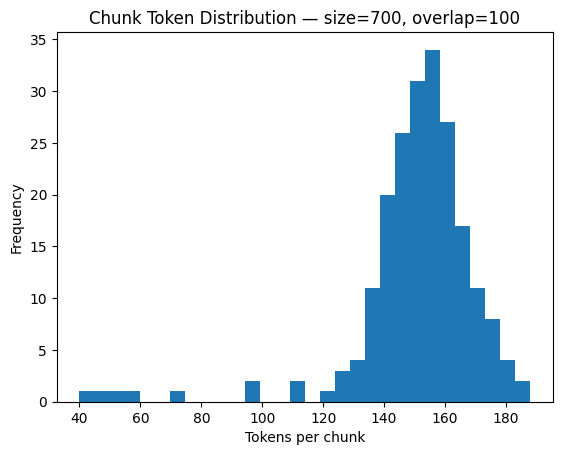

Config size=1000 overlap=150 -> chunks=146, avg=219, min=63, max=263


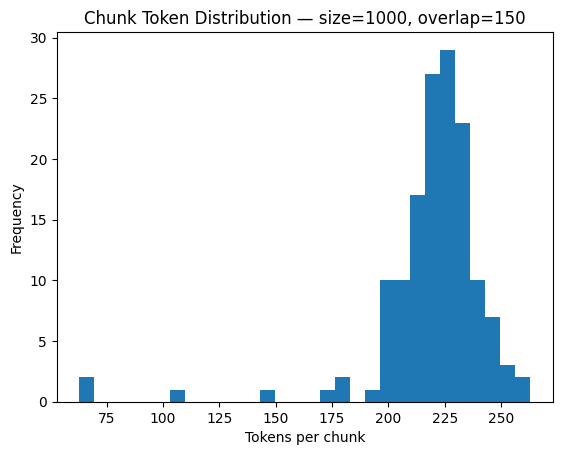

Config size=1500 overlap=200 -> chunks=97, avg=325, min=80, max=373


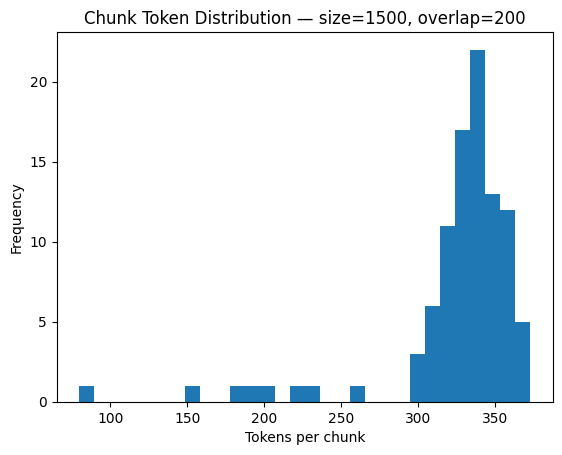

In [17]:
# ============================================================
# D1) Visualize chunk token distributions per config (histogram)
# ============================================================
# Requires: enc (tiktoken encoding), corpus (list of doc texts), configs (list of chunk configs)

from langchain.text_splitter import RecursiveCharacterTextSplitter
import matplotlib.pyplot as plt

# Choose a small sample so charts render fast (tune as you like)
sample_docs = corpus[:10] if len(corpus) >= 10 else corpus

def chunk_tokens_for_config(cfg, docs):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=cfg["chunk_size"],
        chunk_overlap=cfg["overlap"],
        separators=["\n\n", "\n", " ", ""],
    )
    chunks = []
    for d in docs:
        chunks.extend(splitter.split_text(d))
    token_counts = [len(enc.encode(c)) for c in chunks]
    return token_counts

for cfg in configs:
    token_counts = chunk_tokens_for_config(cfg, sample_docs)
    if not token_counts:
        print(f"(no chunks) size={cfg['chunk_size']} overlap={cfg['overlap']}")
        continue

    # Basic stats
    n = len(token_counts)
    avg_tok = sum(token_counts)/n
    print(
        f"Config size={cfg['chunk_size']} overlap={cfg['overlap']} -> "
        f"chunks={n}, avg={avg_tok:.0f}, min={min(token_counts)}, max={max(token_counts)}"
    )

    # One chart per config
    plt.figure()
    plt.hist(token_counts, bins=30)
    plt.title(f"Chunk Token Distribution — size={cfg['chunk_size']}, overlap={cfg['overlap']}")
    plt.xlabel("Tokens per chunk")
    plt.ylabel("Frequency")
    plt.show()


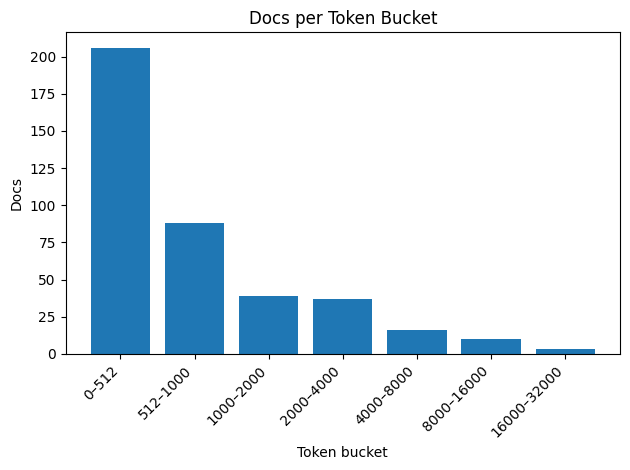

In [20]:
# ============================================================
# E2) (Optional) Visualize estimated embedding cost per doc size bucket
# ============================================================
# Idea: bucket by token count to see where most of your cost will go.
# If you know tokens->cost for your embedding model, you can annotate.

import numpy as np
import matplotlib.pyplot as plt

bins = [0, 512, 1_000, 2_000, 4_000, 8_000, 16_000, 32_000]
hist, edges = np.histogram(doc_token_counts, bins=bins)

labels = [f"{edges[i]}–{edges[i+1]}" for i in range(len(edges)-1)]
plt.figure()
plt.bar(range(len(hist)), hist)
plt.title("Docs per Token Bucket")
plt.xlabel("Token bucket")
plt.ylabel("Docs")
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.tight_layout()
plt.show()


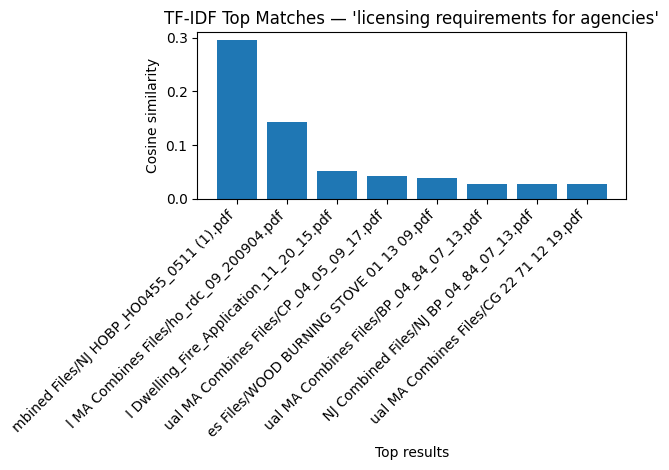

Top matches:
  ('Agency Manual NJ Combined Files', 'NJ HOBP_HO0455_0511 (1).pdf')  -> 0.295
  ('Agency Manual MA Combines Files', 'ho_rdc_09_200904.pdf')  -> 0.143
  ('Agency Manual NJ Combined Files', 'NJ I Dwelling_Fire_Application_11_20_15.pdf')  -> 0.052
  ('Agency Manual MA Combines Files', 'CP_04_05_09_17.pdf')  -> 0.042
  ('Agency Manual MA Combines Files', 'WOOD BURNING STOVE 01 13 09.pdf')  -> 0.038
  ('Agency Manual MA Combines Files', 'BP_04_84_07_13.pdf')  -> 0.028
  ('Agency Manual NJ Combined Files', 'NJ BP_04_84_07_13.pdf')  -> 0.028
  ('Agency Manual MA Combines Files', 'CG 22 71 12 19.pdf')  -> 0.027


In [21]:
# ============================================================
# F1) Visualize TF-IDF search scores for a query (bar chart)
# ============================================================
# Requires: tfidf (fitted), X (tfidf matrix), meta (doc metadata)
# Reminder: scores are cosine similarities (0..1) due to L2 normalization.

from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt

def tfidf_search(query, top_k=10):
    qv = tfidf.transform([query])
    sims = linear_kernel(qv, X).ravel()   # cosine similarity
    idx = sims.argsort()[-top_k:][::-1]
    return idx, sims[idx]

query = "licensing requirements for agencies"  # change to your domain queries
idx, scores = tfidf_search(query, top_k=8)

# Bar chart of top hits
labels = [f"{meta[i][0]}/{meta[i][1]}" for i in idx]
plt.figure()
plt.bar(range(len(scores)), scores)
plt.title(f"TF-IDF Top Matches — '{query}'")
plt.xlabel("Top results")
plt.ylabel("Cosine similarity")
plt.xticks(range(len(labels)), [l[-40:] for l in labels], rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Also print them textually
print("Top matches:")
for i, s in zip(idx, scores):
    print(f"  {meta[i]}  -> {s:.3f}")



Q: licensing requirements for agencies
  -> ('Agency Manual NJ Combined Files', 'NJ HOBP_HO0455_0511 (1).pdf')  (score=0.295)
  -> ('Agency Manual MA Combines Files', 'ho_rdc_09_200904.pdf')  (score=0.143)
  -> ('Agency Manual NJ Combined Files', 'NJ I Dwelling_Fire_Application_11_20_15.pdf')  (score=0.052)
  -> ('Agency Manual MA Combines Files', 'CP_04_05_09_17.pdf')  (score=0.042)
  -> ('Agency Manual MA Combines Files', 'WOOD BURNING STOVE 01 13 09.pdf')  (score=0.038)
  -> ('Agency Manual MA Combines Files', 'BP_04_84_07_13.pdf')  (score=0.028)
  -> ('Agency Manual NJ Combined Files', 'NJ BP_04_84_07_13.pdf')  (score=0.028)
  -> ('Agency Manual MA Combines Files', 'CG 22 71 12 19.pdf')  (score=0.027)


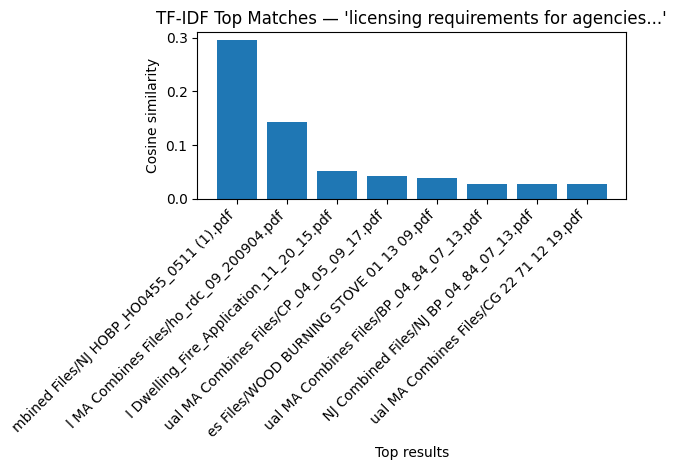


Q: compliance audit procedures
  -> ('Agency Manual NJ Combined Files', 'NJ CG_21_59_04_13.pdf')  (score=0.117)
  -> ('Agency Manual MA Combines Files', 'CG_21_59_04_13.pdf')  (score=0.117)
  -> ('Agency Manual MA Combines Files', 'HO 24 41 09 01 Lead Poisoning Exclusion - MA.pdf')  (score=0.049)
  -> ('Agency Manual NJ Combined Files', 'NJ CG_22_48_04_13.pdf')  (score=0.043)
  -> ('Agency Manual MA Combines Files', 'CG_22_48_04_13.pdf')  (score=0.043)
  -> ('Agency Manual NJ Combined Files', 'NJ CU_21_75_04_13.pdf')  (score=0.043)
  -> ('Agency Manual NJ Combined Files', 'NJ BP_04_84_07_13.pdf')  (score=0.039)
  -> ('Agency Manual MA Combines Files', 'BP_04_84_07_13.pdf')  (score=0.039)


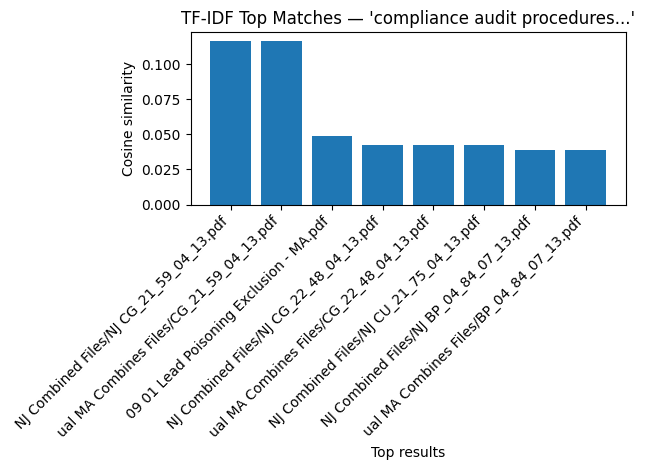


Q: claims processing timeline
  -> ('Agency Manual MA Combines Files', 'CR_35_25_08_07.pdf')  (score=0.142)
  -> ('Agency Manual NJ Combined Files', 'NJ CR_35_25_08_07.pdf')  (score=0.142)
  -> ('Agency Manual MA Combines Files', 'CG_22_48_04_13.pdf')  (score=0.072)
  -> ('Agency Manual NJ Combined Files', 'NJ CG_22_48_04_13.pdf')  (score=0.072)
  -> ('Agency Manual NJ Combined Files', 'NJ CU_21_75_04_13.pdf')  (score=0.071)
  -> ('Agency Manual NJ Combined Files', 'NJ BP_17_24_01_10.pdf')  (score=0.065)
  -> ('Agency Manual MA Combines Files', 'BP_17_24_01_10.pdf')  (score=0.065)
  -> ('Agency Manual NJ Combined Files', 'NJ CU 04 03 12 19.pdf')  (score=0.062)


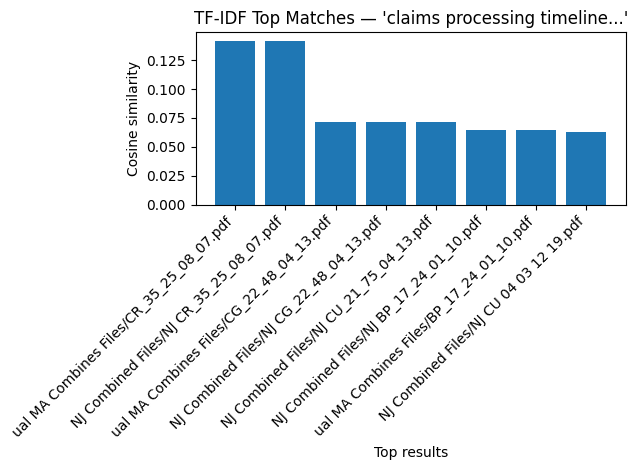

In [23]:
# ------------------------------------------------------------
# Visualize top-k TF-IDF results per query (cosine similarities)
# ------------------------------------------------------------
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt

def search(query, top_k=8):
    qv = tfidf.transform([query])
    sims = linear_kernel(qv, X).ravel()  # cosine similarity
    idx = sims.argsort()[-top_k:][::-1]
    return idx, sims[idx]

for q in queries:
    idx, scores = search(q, top_k=8)
    labels = [f"{meta[i][0]}/{meta[i][1]}" for i in idx]
    print(f"\nQ: {q}")
    for i, s in zip(idx, scores):
        print(f"  -> {meta[i]}  (score={s:.3f})")

    # bar chart
    plt.figure()
    plt.bar(range(len(scores)), scores)
    plt.title(f"TF-IDF Top Matches — '{q[:50]}...'")
    plt.xlabel("Top results")
    plt.ylabel("Cosine similarity")
    plt.xticks(range(len(labels)), [l[-40:] for l in labels], rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
